In [1]:
import requests
import torch
import torch.nn as nn
from PIL import Image
import numpy
import torchvision
from torchvision import transforms
import numpy as np
import cv2
from transformers import ViTImageProcessor, ViTForImageClassification

## Attention rollout

Let's try to understand how ViT models see the world. To visualise what details on images are important for the model we will apply a technique called [Attention Rollout](https://arxiv.org/abs/2005.00928). This technique was originally introduced for NLP tasks to visualise information flow between word tokens. However, the same technique can be applied to visualise information propagation through [ViT](https://arxiv.org/abs/2010.11929) (Figure 6 and Figure 14).


Let's start with uploading a ViT model. We will use a classical ViT model ViT-L, however feel free to experiment with other ViT architectures.

In [2]:
MODEL_NAME = "google/vit-large-patch16-224"
# other possible variants you might want to check
# google/vit-base-patch16-224
# google/vit-huge-patch14-224-in21k

# facebook/deit-small-patch16-224 https://arxiv.org/abs/2012.12877
# facebook/deit-base-patch16-224

processor = ViTImageProcessor.from_pretrained(MODEL_NAME)
model = ViTForImageClassification.from_pretrained(MODEL_NAME)

model = model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Let's check that our model works as expected.

In [3]:
url = 'https://t3.ftcdn.net/jpg/00/01/47/28/360_F_1472821_kMjcU0El8NkcU0k7zNtlVTU0Fl8W2l.jpg'
image = Image.open(requests.get(url, stream=True).raw)

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs, output_attentions=True)

logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: airliner


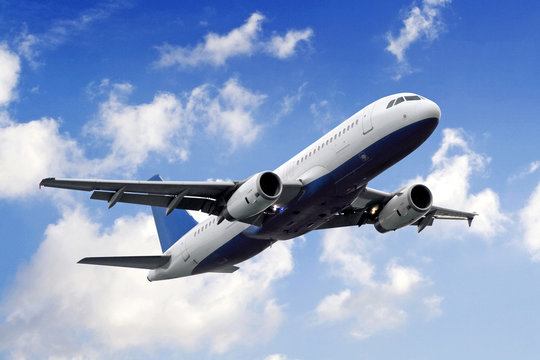

In [4]:
image

Pay attention that we used a flag "output_attentions=True" [(link how it is computed)](https://github.com/huggingface/transformers/blob/c48787f347bd604f656c2cfff730e029c8f8c1fe/src/transformers/models/vit/modeling_vit.py#L224) above to get attention weights for all self attention layers in the model.

ViT-L model has 24 Transformer layers and each self attention layer has 16 heads.

In [5]:
n_layers = len(outputs.attentions)
_, num_heads, n_tokens, _ = outputs.attentions[0].shape
print(f"number of layers: {n_layers}")
print(f"number of heads: {num_heads}")
print(f"number of tokens: {n_tokens} (including one cls_token)")

number of layers: 24
number of heads: 16
number of tokens: 197 (including one cls_token)


Let's briefly describe how [Attention Rollout](https://arxiv.org/abs/2005.00928) works.

<img src="https://samiraabnar.github.io/img/flow_images/attention_rollout.gif" width="500" align="center">


We compute values for all tokens at layer $l + 1$ based on attention weights $W_{\textit{attn}} = \textit{softmax}(\frac{Q K^T}{\sqrt(d)})$ multiplied by values $V_l$ and then we add a skip connection. We can write this as

$$ V_{l+1} = V_l + W_{\textit{attn}} V_l $$

or

$$ V_{l+1} = (I + W_{\textit{attn}}) V_l $$

where $I$ is an identity matrix.


<img src="https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png" width=500 align="center">

Based on this observation authors proposed a method that recoursively multiply the attention weights matrices, starting from the input layer up to layer $l$.

The algorithm looks like (in case of a single head):

1. Initialize the result matrix $\hat{A}$ as an identity matrix $R^{L \times L}$ where $L$ is a number of tokens (including class token).
2. for layer_idx in range(num_layers):

a) compute matrix $U \in R^{L \times L}$ $$ U = 0.5 * (W_{\textit{attn}} + I) $$
 where $I$ is an identity matrix $R^{L \times L}$ and $W_{\textit{attn}}$ is an attention weights matrix at layer layer_idx

b) Normalize $U$ that rows are summed up to 1

c) Update the result matrix $\hat{A}$
$$ \hat{A} = U \hat{A} $$
    


The algorithm above works for a single head use case. To extend the algorithm for attention mechanism with many heads we can simply fuse all heads using mean operation (just compute mean values over the head dimension).

In [51]:
result = torch.eye(n_tokens)
attentions = [x.clone() for x in outputs.attentions]
I = torch.eye(n_tokens)

for w_attn in attentions:
    # w_attn.shape is batch_size, n_heads, n_tokens, n_tokens
    w_attn_head_fused = w_attn.mean(dim=1)
    # w_attn_head_fused.shape is (batch_size, n_tokens, n_tokens)

    # compute matrix U with shape (batch_size, n_tokens, n_tokens)
    U = 0.5 * (w_attn_head_fused + I)
    # print(U.shape)

    # normalize matrix U
    U_sum = U.sum(dim=-1, keepdim=True)
    U_normalized = U / U_sum

    # update result matrix
    result = U_normalized @ result


assert result.shape[-2:] == (n_tokens, n_tokens)

In [52]:
def convert_result_to_mask(mat):
    assert mat.shape == (1, n_tokens, n_tokens)
    # take weights between class token and other tokens
    saliency_map = mat[0, 0 , 1:]

    # n_tokens^2 = Height * Width / patch_size^2
    img_size = int(n_tokens**0.5)

    saliency_map = saliency_map.reshape(img_size, img_size).numpy()
    saliency_map = saliency_map / np.max(saliency_map)
    return saliency_map

In [53]:
saliency_map = convert_result_to_mask(result)
np_img = np.array(image)[:, :, ::-1]
saliency_map = cv2.resize(saliency_map, (np_img.shape[1], np_img.shape[0]))

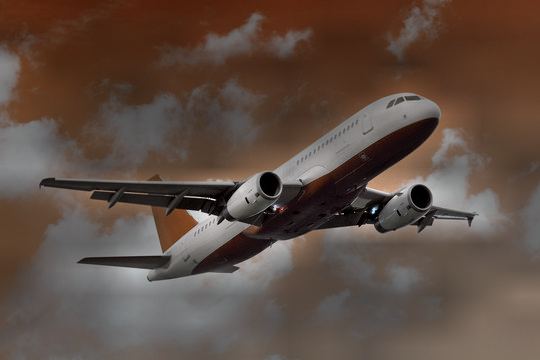

In [54]:
Image.fromarray(((np_img / 255. * saliency_map[...,None]) * 255).astype(np.uint8))

As you can see the result is not super clear. We can improve it by zeroing attention weights corresponding to lowest attention values. In other words, we can take $W_{\textit{attn}}$ matrix and for example make 70% of the smallest attention values equal to zero. Can you try to modify the algorithm above and check what changes in the result?

Don't forget not to zero attention weights between class token and other tokens.

In [57]:
result = torch.eye(n_tokens)
DROP_LOWEST_ATTN_FRACTION = 0.7
I = torch.eye(n_tokens)

attentions = [x.clone() for x in outputs.attentions]

for w_attn in attentions:
    w_attn_head_fused = w_attn.mean(dim=1)

    # for simplicity let's create a flattened view of a tensor w_attn_head_fused
    view_w_attn_head_fused = w_attn_head_fused.view(w_attn_head_fused.size(0), -1)
    # view_w_attn_head_fused.shape is batch_size, n_tokens**2

    # remainder:
    # when you modify values in a tensor view you also modify values in the original tensor
    # https://pytorch.org/docs/stable/tensor_view.html
    # PASTE YOUR CODE HERE
    min_attn = torch.quantile(view_w_attn_head_fused, DROP_LOWEST_ATTN_FRACTION, keepdim=True)

    w_attn_head_fused[:, :n_tokens - 1, :n_tokens - 1] = torch.where(
        w_attn_head_fused[:, :n_tokens - 1, :n_tokens - 1] > min_attn,
        w_attn_head_fused[:, :n_tokens - 1, :n_tokens - 1],
        0.
    )

    U = 0.5 * (w_attn_head_fused + I)
    U_sum = U.sum(dim=-1, keepdim=True)
    U_normalized = U / U_sum
    result = U_normalized @ result

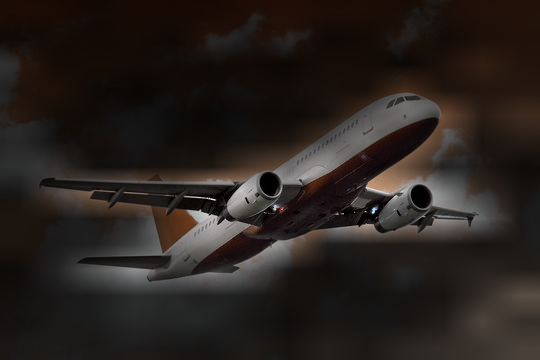

In [58]:
saliency_map = convert_result_to_mask(result)
np_img = np.array(image)[:, :, ::-1]
saliency_map = cv2.resize(saliency_map, (np_img.shape[1], np_img.shape[0]))
Image.fromarray(((np_img / 255. * saliency_map[...,None]) * 255).astype(np.uint8))

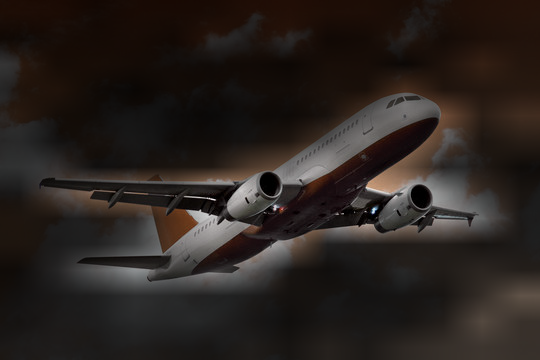

In [ ]:
saliency_map = convert_result_to_mask(result)
np_img = np.array(image)[:, :, ::-1]
saliency_map = cv2.resize(saliency_map, (np_img.shape[1], np_img.shape[0]))
Image.fromarray(((np_img / 255. * saliency_map[...,None]) * 255).astype(np.uint8))